# Chapter 1_1 线性回归
----
Author: W.Y.  
Date: 2019/12/31  
Info: 王汉生老师书的第一章，线性回归的python极简实现  

----

In [1]:
# 导入模块

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib
import statsmodels.formula.api as smf  
import lmdiag  
from patsy import dmatrices  
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from SelfModule import stepwiseSelection

In [2]:
# 导入数据之导入txt文件  

data = pd.read_csv('E:/Data Mining/SimplePython/Chapter 1 从R到Python/CH 1_1 线性回归/CH 1_1 data.txt', sep = '\s+')

In [3]:
# 预览数据（方法一）

data.head(10)

,year,ROEt,ATO,PM,LEV,GROWTH,PB,ARR,INV,ASSET,ROE
0,2002,0.296,0.389,0.215,4.384,0.197,8.048,0.637,0.248,20.873,0.181
1,2002,0.665,0.335,0.407,2.273,-0.084,2.154,-1.217,0.030,21.062,0.899
2,2002,-0.045,0.963,0.084,-5.339,4.155,-12.879,-0.598,0.096,21.474,1.504
3,2002,-0.783,0.437,-0.096,1.016,2.231,3.836,0.056,0.051,19.746,-0.777
4,2002,1.053,0.858,-0.154,-2.066,0.519,1.972,0.293,0.032,22.570,0.728
5,2002,0.590,0.528,0.197,-0.946,-1.441,2.405,-0.986,0.189,20.890,1.141
6,2002,-0.204,0.419,0.324,3.513,1.999,8.827,0.389,-0.060,21.965,0.568
7,2002,-0.845,0.891,0.131,4.628,1.733,7.522,-0.471,0.145,20.377,-0.171
8,2002,-0.065,-0.230,0.071,1.525,-2.436,-14.887,0.958,0.215,20.480,0.415
9,2002,1.001,-0.176,0.123,-0.891,2.257,-12.065,-0.336,0.065,20.455,0.699


In [4]:
# 预览数据（方法二）

pd.DataFrame.head(data,5)

,year,ROEt,ATO,PM,LEV,GROWTH,PB,ARR,INV,ASSET,ROE
0,2002,0.296,0.389,0.215,4.384,0.197,8.048,0.637,0.248,20.873,0.181
1,2002,0.665,0.335,0.407,2.273,-0.084,2.154,-1.217,0.030,21.062,0.899
2,2002,-0.045,0.963,0.084,-5.339,4.155,-12.879,-0.598,0.096,21.474,1.504
3,2002,-0.783,0.437,-0.096,1.016,2.231,3.836,0.056,0.051,19.746,-0.777
4,2002,1.053,0.858,-0.154,-2.066,0.519,1.972,0.293,0.032,22.570,0.728


In [5]:
# 数据分割，2002年用来建模，2003年用来预测

data2002 = data[data['year'] == 2002]
data2003 = data[data.year == 2003]

In [6]:
# 描述性分析（方法一：单独计算）

mean_ROEt = np.mean(data2002['ROEt'])  # 均值
median_ATO = np.median(data2002['ATO'])  # 中位数
var_PM = np.var(data2002['PM'])  # 方差
min_LEV = min(data2002['LEV'])  # 最小值
max_GROWTH = max(data2002['GROWTH'])  # 最大值
std_PB = np.std(data2002['PB'])  # 标准差

print('mean_ROEt:', mean_ROEt, 
      '\nmedian_ATO:', median_ATO,
      '\nvar_PM:', var_PM,
      '\nmin_LEV:', min_LEV,
      '\nmax_GROWTH:', max_GROWTH,
      '\nstd_PB:', std_PB) 

mean_ROEt: 0.067778 
median_ATO: 0.4375 
var_PM: 0.032730709696000004 
min_LEV: -7.941 
max_GROWTH: 6.0920000000000005 
std_PB: 9.503158413643126


In [7]:
# 描述性分析（方法二：统一计算）

df_describe = pd.concat([data2002.min(), data2002.max(),
                         data2002.median(), data2002.mean(),
                         data2002.var(), data2002.std()], axis=1)
df_describe.columns = ['min', 'max', 'median', 'mean', 'var', 'std']  # 重命名列名
df_describe

,min,max,median,mean,var,std
year,2002.000,2002.000,2002.0000,2002.000000,0.000000,0.000000
ROEt,-1.390,1.421,0.0800,0.067778,0.269285,0.518927
ATO,-0.928,1.927,0.4375,0.429818,0.211972,0.460404
PM,-0.424,0.698,0.2180,0.210952,0.032796,0.181097
LEV,-7.941,9.362,0.5595,0.708852,10.127351,3.182350
GROWTH,-5.962,6.092,0.3790,0.331254,4.496266,2.120440
PB,-20.816,32.591,2.2710,2.126802,90.491002,9.512676
ARR,-2.601,3.187,0.2230,0.200780,0.899864,0.948612
INV,-0.264,0.431,0.1020,0.100044,0.014985,0.122412
ASSET,18.629,23.414,21.0565,21.066002,0.730640,0.854775


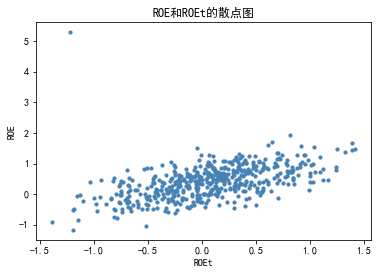

In [8]:
# 绘制散点图

matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 为了画图能够显示中文，否则中文会变成乱码。
plt.rcParams['axes.unicode_minus']=False  # 画图正常显示负号

plt.scatter(x = data2002.ROEt, # 指定散点图的x轴数据
            y = data2002.ROE, # 指定散点图的y轴数据
            s = 10,  # 指定散点图点的大小
            c = 'steelblue') # 指定散点图中点的颜色
plt.xlabel('ROEt') # 添加x轴标签
plt.ylabel('ROE')  # 添加y轴标签
plt.title('ROE和ROEt的散点图')  # 添加标题
plt.show()  # 显示图形

In [9]:
# 相关分析

data.iloc[:, 1:11].corr()


,ROEt,ATO,PM,LEV,GROWTH,PB,ARR,INV,ASSET,ROE
ROEt,1.000000,0.044154,0.097517,-0.246938,0.042447,-0.225358,-0.072549,-0.029289,0.136143,0.571646
ATO,0.044154,1.000000,-0.271664,-0.035780,0.004386,-0.054330,-0.116588,0.105438,0.069282,0.033027
PM,0.097517,-0.271664,1.000000,-0.146390,0.025565,-0.056361,-0.402270,-0.097302,0.023362,0.091275
LEV,-0.246938,-0.035780,-0.146390,1.000000,-0.028151,0.746345,0.059813,0.036031,-0.019070,-0.297254
GROWTH,0.042447,0.004386,0.025565,-0.028151,1.000000,-0.018986,-0.034048,0.043191,-0.029855,0.098837
PB,-0.225358,-0.054330,-0.056361,0.746345,-0.018986,1.000000,0.001873,-0.025658,-0.188374,-0.236556
ARR,-0.072549,-0.116588,-0.402270,0.059813,-0.034048,0.001873,1.000000,-0.051356,-0.086433,-0.090626
INV,-0.029289,0.105438,-0.097302,0.036031,0.043191,-0.025658,-0.051356,1.000000,0.021881,-0.020789
ASSET,0.136143,0.069282,0.023362,-0.019070,-0.029855,-0.188374,-0.086433,0.021881,1.000000,0.085186
ROE,0.571646,0.033027,0.091275,-0.297254,0.098837,-0.236556,-0.090626,-0.020789,0.085186,1.000000


In [10]:
# 一元线性回归 （x = ROEt, y = ROE）

model1 = smf.ols("ROE ~ ROEt", 
            data2002).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     179.9
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           3.10e-35
Time:                        17:33:55   Log-Likelihood:                -328.19
No. Observations:                 500   AIC:                             660.4
Df Residuals:                     498   BIC:                             668.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3738      0.021     17.734      0.0

In [11]:
# 多元线性回归 （x = ROEt+ATO+PM+LEV+GROWTH+PB+ARR+INV+ASSET, y = ROE）

model2 = smf.ols("ROE ~ ROEt + ATO + PM + LEV + GROWTH + PB + ARR + INV + ASSET", 
            data2002).fit()
model2.summary()  # 请品一品用print()和没用print()的区别

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROE   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     24.79
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           4.24e-35
Time:                        17:33:55   Log-Likelihood:                -311.46
No. Observations:                 500   AIC:                             642.9
Df Residuals:                     490   BIC:                             685.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4544      0.528      0.860      0.390      -0.584       1.492
ROEt           0.4875      0.041     11.875      0.000       0.407       0.568
ATO           -0.0147      0.048     -0.309      0.758      -0.108       0.079
PM             0.0788      0.133      0.592      0.554      -0.183       0.341
LEV           -0.0397      0.011     -3.770      0.000      -0.060      -0.019
GROWTH         0.0199      0.010      2.068      0.039       0.001       0.039
PB             0.0033      0.003      0.954      0.341      -0.004       0.010
ARR           -0.0260      0.024     -1.069      0.285      -0.074       0.022
INV           -0.0198      0.168     -0.118      0.906      -0.351       0.311
ASSET         -0.0031      0.025     -0.125      0.901      -0.052       0.046
==============================================================================
Omnibus:                      439.894   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33004.079
Skew:                           3.341   Prob(JB):                         0.00
Kurtosis:                      42.237   Cond. No.                         552.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

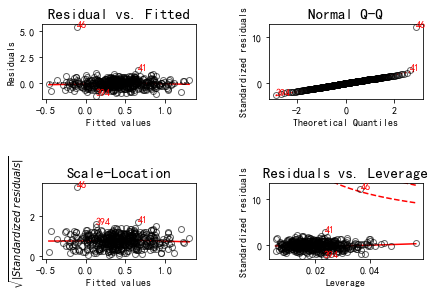

In [12]:
# 模型诊断（画图）
lmdiag.plot(model2)


In [13]:
# 删除异常值（参考书上，删除第46个值）

data2002_a = data2002.drop([46])

In [14]:
# 再次回归

model3 = smf.ols("ROE ~ ROEt + ATO + PM + LEV + GROWTH + PB + ARR + INV + ASSET", 
            data2002_a).fit()
print(model3.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     40.01
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           2.63e-53
Time:                        17:34:00   Log-Likelihood:                -223.57
No. Observations:                 499   AIC:                             467.1
Df Residuals:                     489   BIC:                             509.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5615      0.444      1.266      0.2

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

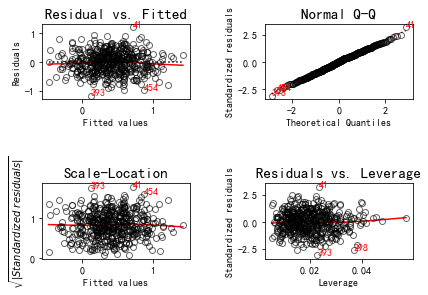

In [15]:
# 再次诊断

lmdiag.plot(model3)


In [16]:
# 共线性诊断

y, X = dmatrices( 'ROE ~ ROEt + ATO + PM + LEV + GROWTH + PB + ARR + INV + ASSET', 
                  data = data2002_a, return_type= 'dataframe')

vif = pd.DataFrame()  # 构造空的数据框
vif["variables"] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,vif
0,Intercept,670.886077
1,ROEt,1.092696
2,ATO,1.151425
3,PM,1.395851
4,LEV,2.699114
5,GROWTH,1.004474
6,PB,2.629386
7,ARR,1.279575
8,INV,1.020351
9,ASSET,1.089989


In [17]:
# 变量选择

X_train = data2002_a.iloc[:, 1:10]

In [18]:
# AIC

stepwiseSelection.backwardSelection(X_train, data2002_a['ROE'])

# python没有和R中step函数一样的第三方模块，此处需要导入自定义模块，具体请查看note版本和番外。

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : INV
Eliminated : PM
Eliminated : ASSET
Eliminated : PB
Eliminated : ATO
Eliminated : ARR
Regained :  ARR
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     89.62
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           3.12e-57
Time:                        17:34:08   Log-Likelihood:                -225.12
No. Observations:                 499   AIC:                             460.2
Df Residuals:                     494   BIC:                             481.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    

(['intercept', 'ROEt', 'LEV', 'GROWTH', 'ARR'],
 '\n                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                    ROE   R-squared:                       0.424\nModel:                            OLS   Adj. R-squared:                  0.413\nMethod:                 Least Squares   F-statistic:                     40.01\nDate:                Mon, 03 Feb 2020   Prob (F-statistic):           2.63e-53\nTime:                        17:34:07   Log-Likelihood:                -223.57\nNo. Observations:                 499   AIC:                             467.1\nDf Residuals:                     489   BIC:                             509.3\nDf Model:                           9                                         \nCovariance Type:            nonrobust                                         \n====================================================================

In [19]:
model_aic = smf.ols("ROE ~ ROEt + LEV + GROWTH + ARR", 
            data2002_a).fit()

In [20]:
# BIC

stepwiseSelection.backwardSelection(X_train, data2002_a['ROE'], elimination_criteria='bic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : INV
Eliminated : PM
Eliminated : ASSET
Eliminated : PB
Eliminated : ATO
Eliminated : ARR
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     117.6
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           1.60e-57
Time:                        17:34:08   Log-Likelihood:                -226.95
No. Observations:                 499   AIC:                             461.9
Df Residuals:                     495   BIC:                             478.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

(['intercept', 'ROEt', 'LEV', 'GROWTH'],
 '\n                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                    ROE   R-squared:                       0.424\nModel:                            OLS   Adj. R-squared:                  0.413\nMethod:                 Least Squares   F-statistic:                     40.01\nDate:                Mon, 03 Feb 2020   Prob (F-statistic):           2.63e-53\nTime:                        17:34:08   Log-Likelihood:                -223.57\nNo. Observations:                 499   AIC:                             467.1\nDf Residuals:                     489   BIC:                             509.3\nDf Model:                           9                                         \nCovariance Type:            nonrobust                                         \n===========================================================================

In [21]:
model_bic = smf.ols("ROE ~ ROEt + LEV", 
            data2002_a).fit()

# 可能是计算方法不同，python和R计算出来的AIC和BIC值不一样，所以选择出来的变量也不同，具体查看note版本的说明吧。
# 为了后面的结果的对比，这里就用了和书上一样的变量，但是上面根据bic计算的其实有三个变量。

In [22]:
# 预测

true = data2003['ROE']
predict1 = model3.predict(data2003)
predict_aic = model_aic.predict(data2003)
predict_bic = model_bic.predict(data2003)

In [23]:
# 误差值= 真实值-预测值

resid0 = true - data2003['ROEt']
resid1 = true - predict1
resid_aic = true - predict_aic
resid_bic = true - predict_bic

In [24]:
# 求平均误差（误差的均值）

resid_result = abs(pd.DataFrame(list(zip(resid0, resid1, resid_aic, resid_bic)))) 
resid_result.mean()


0    0.415732
1    0.294452
2    0.293725
3    0.294786
dtype: float64